In [2]:
# Clone the Repository
!git clone https://github.com/jonarnar/HighResCanopyHeight.git
%cd HighResCanopyHeight

Cloning into 'HighResCanopyHeight'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 57 (delta 19), reused 34 (delta 10), pack-reused 10 (from 1)
Receiving objects: 100% (57/57), 2.70 MiB | 29.38 MiB/s, done.
Resolving deltas: 100% (19/19), done.
/content/HighResCanopyHeight


In [19]:
# Install Dependencies Specified In SetUp Guide
!pip install pip==24.0
!pip install numpy==1.26.4 pytorch-lightning==1.7 torch==2.0.1 torchvision==0.15.2 torchmetrics==0.11.4 pillow==11.0.0 pandas==2.2.3 matplotlib==3.9.4
!pip install transformers==4.38.2
!pip install awscli


DEPRECATION: pytorch-lightning 1.7.0 has a non-standard dependency specifier torch>=1.9.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: pytorch-lightning 1.7.0 has a non-standard dependency specifier torch>=1.9.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.7/130.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 57.4 MB/s eta 0:00:00

In [1]:
# Download the Pretrained Model Data
%cd HighResCanopyHeight
!aws s3 --no-sign-request cp --recursive s3://dataforgood-fb-data/forests/v1/models/ .
!unzip data.zip
!rm data.zip

/content/HighResCanopyHeight
download: s3://dataforgood-fb-data/forests/v1/models/saved_checkpoints/aerial_normalization_quantiles_predictor.ckpt to saved_checkpoints/aerial_normalization_quantiles_predictor.ckpt
download: s3://dataforgood-fb-data/forests/v1/models/saved_checkpoints/compressed_SSLlarge.pth to saved_checkpoints/compressed_SSLlarge.pth
download: s3://dataforgood-fb-data/forests/v1/models/saved_checkpoints/compressed_SSLhuge.pth to saved_checkpoints/compressed_SSLhuge.pth
download: s3://dataforgood-fb-data/forests/v1/models/saved_checkpoints/compressed_SSLhuge_aerial.pth to saved_checkpoints/compressed_SSLhuge_aerial.pth
download: s3://dataforgood-fb-data/forests/v1/models/saved_checkpoints/SSLhuge_satellite.pth to saved_checkpoints/SSLhuge_satellite.pth
download: s3://dataforgood-fb-data/forests/v1/models/data.zip to ./data.zip
Archive:  data.zip
   creating: data/.ipynb_checkpoints/
   creating: data/images/
  inflating: data/images/2017_WLOU_1_NEON_D13_WLOU_DP3_419000_

In [12]:
# Remove the files we're not using from data.
!rm -rf data/*

# Download the data provided by Jón Arnar
!wget orbcarbon.com/trees.zip

# Unzip it and remove zip file
!unzip trees.zip
!rm trees.zip

# Move images to data folder
!mv output_images data/images

--2025-05-05 17:38:53--  http://orbcarbon.com/trees.zip
Resolving orbcarbon.com (orbcarbon.com)... 89.147.110.106
Connecting to orbcarbon.com (orbcarbon.com)|89.147.110.106|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64010744 (61M) [application/zip]
Saving to: ‘trees.zip’

trees.zip           100%[===================>]  61.04M  14.1MB/s    in 5.6s    

2025-05-05 17:39:00 (10.9 MB/s) - ‘trees.zip’ saved [64010744/64010744]

Archive:  trees.zip
   creating: output_images/
  inflating: output_images/59903.png  
  inflating: output_images/59897.png  
  inflating: output_images/59628.png  
  inflating: output_images/53939.png  
  inflating: output_images/53490.png  
  inflating: output_images/52559.png  
  inflating: output_images/52218.png  
  inflating: output_images/51694.png  
  inflating: output_images/51596.png  
  inflating: output_images/51208.png  
  inflating: output_images/51207.png  
  inflating: output_images/50127.png  
  inflating: output_images/

In [15]:
import os
import csv

file_list = sorted(os.listdir('./data/images/'))

with open("data.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["", "index", "image"])  # header with leading comma
    for idx, filename in enumerate(file_list):
        index = int(filename[:-4])
        writer.writerow([idx, index, filename])

In [16]:
!mv data.csv ./data/data.csv

In [13]:
import fileinput
# Inserts a dummy compiler, since torch v2.0.1 doesn't have a compiler.

# block to insert.
block = '''if not hasattr(torch, "compiler"):
    class DummyCompiler:
        @staticmethod
        def disable(*args, **kwargs):
            def decorator(func):
                return func
            return decorator
    torch.compiler = DummyCompiler()
'''

# Open inference.py for in-place editing.
with fileinput.input('./inference.py', inplace=True) as file:
    for line_number, line in enumerate(file, 1):
        print(line, end='')
        # After line 8 (which is "import torch"), block is inserted.
        if line_number == 8:
            print(block, end='')


In [14]:
!head -n 20 inference.py

# Copyright (c) Meta Platforms, Inc. and affiliates.
#
# This source code is licensed under the Apache License, Version 2.0
# found in the LICENSE file in the root directory of this source tree.

import argparse
import os
import torch
if not hasattr(torch, "compiler"):
    class DummyCompiler:
        @staticmethod
        def disable(*args, **kwargs):
            def decorator(func):
                return func
            return decorator
    torch.compiler = DummyCompiler()
import pandas as pd
import numpy as np
import torchvision.transforms as T
import matplotlib.pyplot as plt


In [20]:
# Run the Inference
!python inference.py --csv ./data/data.csv --image_dir ./data/images/ --name output_inference



2025-05-05 17:48:28.218289: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746467308.500230   10129 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746467308.571458   10129 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
normtype 2
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze i

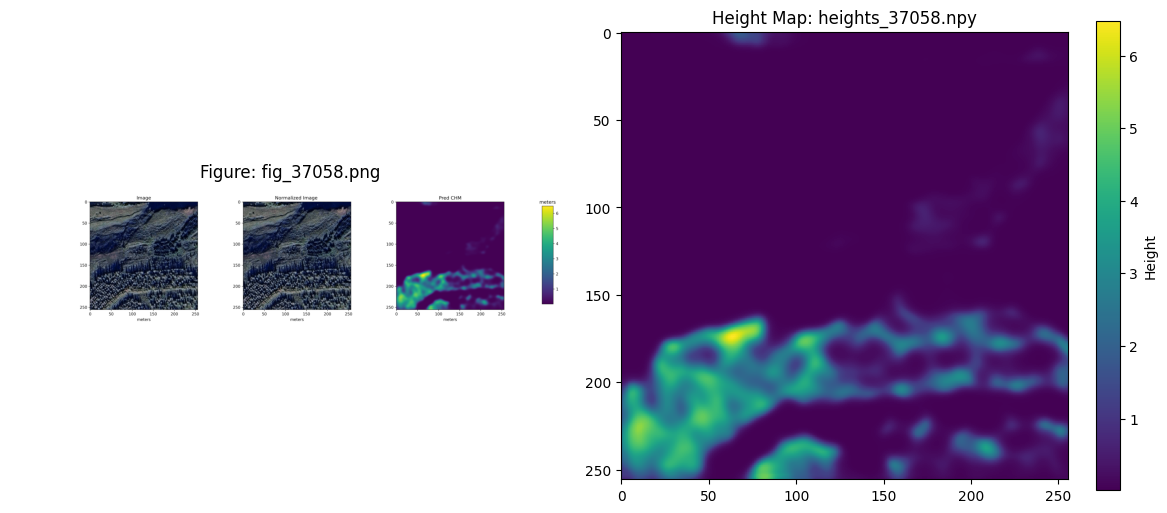

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

# Path to the output folder
output_dir = "output_inference"

# File names
png_filename = "fig_37058.png"
npy_filename = "heights_37058.npy"

# Build full file paths
png_path = os.path.join(output_dir, png_filename)
npy_path = os.path.join(output_dir, npy_filename)

# Load the PNG image
fig_img = Image.open(png_path)

# Load the height map numpy array
heights = np.load(npy_path)

# Create a figure with two subplots
plt.figure(figsize=(12, 5))

# Display the PNG image
plt.subplot(1, 2, 1)
plt.imshow(fig_img)
plt.title("Figure: " + png_filename)
plt.axis('off')

# Display the height map as a heatmap
plt.subplot(1, 2, 2)
plt.imshow(heights, cmap='viridis')
plt.title("Height Map: " + npy_filename)
plt.colorbar(label="Height")
plt.tight_layout()
plt.show()


In [25]:
%ls

CODE_OF_CONDUCT.md  inference.py  output.gpkg        saved_checkpoints/
CONTRIBUTING.md     LICENSE       output_inference/
data/               models/       pl_modules/
fig_0_1_2.png       notebooks/    README.md


In [26]:
import shutil

# Zip output.
folder_path = "./output_inference"
zip_path = "./output_inference.zip"

shutil.make_archive(zip_path.replace(".zip", ""), 'zip', folder_path)


'/content/HighResCanopyHeight/output_inference.zip'

In [27]:
from google.colab import files

files.download(zip_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>